# Setup

# Install Dependencies

In [4]:
!pip install opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


# Import Dependencies

In [1]:
import cv2
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

# Create Folder Structures

In [2]:
# Setup paths
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

In [16]:
# Making Folders
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

 # Collect Positives and Anchors

# Untar Labelled Faces in the Wild Dataset

In [23]:
for directory in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw", directory)):
        EX_PATH = os.path.join("lfw", directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# Collect Positive and Anchor Classes

In [3]:
import uuid

In [4]:
uuid.uuid1()

UUID('3f2d2e32-a6aa-11ed-8976-6018953feb89')

In [113]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[205:205+250,250:250+250, :]
    
    # collect anchors
    if cv2.waitKey(1) & 0xFF == ord("a"):
        imgname = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    # collect positives
    if cv2.waitKey(1) & 0xFF == ord("p"):
        imgname = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
        
    cv2.imshow("Image Collection", frame)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

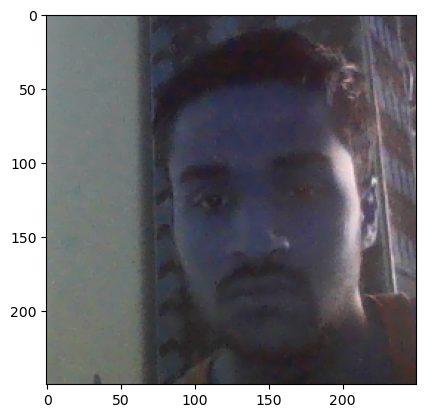

In [114]:
plt.imshow(frame)

ValueError: zero-size array to reduction operation minimum which has no identity

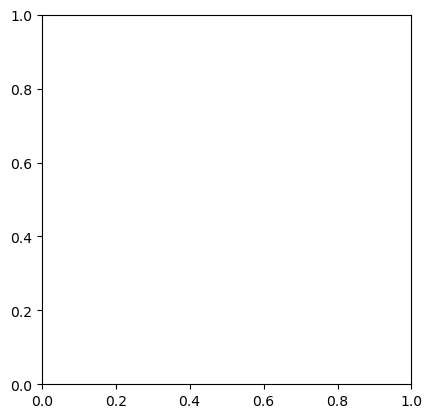

In [207]:
plt.imshow(frame[205:205+250,250:250+250, :])

# Load and Preprocess Images

# Get Image Directories 

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH + "\*.jpg").take(300)
positive = tf.data.Dataset.list_files(POS_PATH + "\*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + "\*.jpg").take(300)

In [9]:
ANC_PATH + "\*.jpg"

'data\\anchor\\*.jpg'

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
dir_test.next()

b'data\\anchor\\5cd2996c-a57f-11ed-8fdd-6018953feb89.jpg'

# Preprocessing - Scale and Resize

In [116]:
def preprocess(file_path):
    
    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    
    # preprocessing the image
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    # return image
    return img

In [117]:
img = preprocess('data\\anchor\\5cd2996c-a57f-11ed-8fdd-6018953feb89.jpg')

In [118]:
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.61691177, 0.6247549 , 0.62083334],
        [0.62058824, 0.6284314 , 0.6166667 ],
        [0.61985296, 0.6276961 , 0.6159314 ],
        ...,
        [0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843]],

       [[0.6117647 , 0.6117647 , 0.6122549 ],
        [0.6068627 , 0.6129902 , 0.6014706 ],
        [0.6068627 , 0.61446077, 0.6007353 ],
        ...,
        [0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843]],

       [[0.60882354, 0.60294116, 0.60784316],
        [0.60612744, 0.6071078 , 0.59632355],
        [0.6017157 , 0.60857844, 0.5889706 ],
        ...,
        [0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843],
        [0.99215686, 1.        , 0.99607843]],

       ...,

       [[0.47990197, 0.53088236, 0.5034314 ],
        [0.48

In [15]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

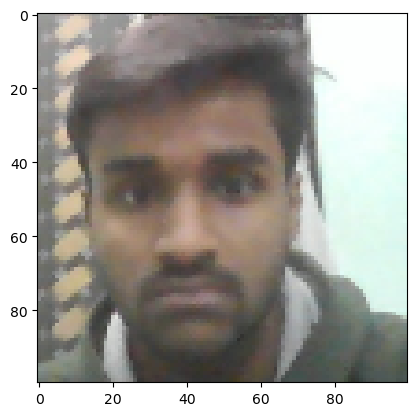

In [119]:
plt.imshow(img)

In [120]:
img.numpy().min()

0.1384804

In [121]:
img.numpy().max()

1.0

# Create Labelled Dataset

In [25]:
# (anchor, positive) => 1,1,1,1
# (anchor, negative) => 0,0,0,0


In [122]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [123]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [124]:
samples = data.as_numpy_iterator()

In [125]:
example = samples.next()

In [126]:
example

(b'data\\anchor\\601a5a12-a57f-11ed-a857-6018953feb89.jpg',
 b'data\\positive\\80c5447f-a57f-11ed-925c-6018953feb89.jpg',
 1.0)

# Build Train and Test Partition

In [127]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [128]:
res = preprocess_twin(*example)

In [129]:
len(res)

3

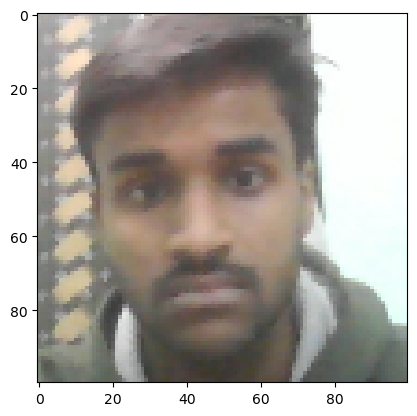

In [130]:
plt.imshow(res[1])

In [131]:
res[2]

1.0

In [132]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [133]:
sample = data.as_numpy_iterator()

In [134]:
len(sample.next())

3

In [135]:
samp = sample.next()

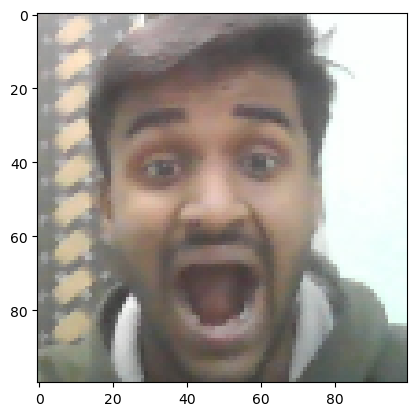

In [136]:
plt.imshow(samp[1])

In [30]:
samp[2]

1.0

In [31]:
# Traning Partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [32]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [33]:
train_samples = train_data.as_numpy_iterator()

In [34]:
train_samples = train_samples.next()

In [137]:
len(train_samples[0])

16

In [138]:
# Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

# Build Embedding Layer

In [139]:
inp = Input(shape=(105,105,3), name = "input_image")

In [140]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [141]:
c1 = Conv2D(64, (10,10), activation="relu")(inp)

In [142]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d_5')>

In [143]:
m1 = MaxPooling2D(64, (2,2), padding="same")(c1)

In [144]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d_3')>

In [150]:
c2 = Conv2D(128, (7,7), activation="relu")(m1)
m2 = MaxPooling2D(64, (2,2), padding="same")(c2)
    

In [151]:
mod = Model(inputs = [inp] ,outputs = [d1] ,name = "embedding")

In [152]:
mod.summary()


Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 18, 18, 128)       26

In [149]:
c4 = Conv2D(256, (4,4), activation="relu")(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation="sigmoid")(f1)    

In [148]:
c3 = Conv2D(128, (4,4), activation="relu")(m2)
m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

In [153]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = "input_image")
    
    # First Block
    c1 = Conv2D(64, (10,10), activation="relu")(inp)
    m1 = MaxPooling2D(64, (2,2), padding="same")(c1)
    
    # Second Block
    c2 = Conv2D(128, (7,7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2,2), padding="same")(c2)
    
    # Third Block
    c3 = Conv2D(128, (4,4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2,2), padding="same")(c3)
    
    # Fourth Layer
    c4 = Conv2D(256, (4,4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    
    return Model(inputs = [inp] ,outputs = [d1] ,name = "embedding")

In [154]:
embedding = make_embedding()

In [155]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 17, 17, 128)       26

# Build Distance Layer

In [156]:
# Siamese L1 distance class
class L1Dist(Layer):
    
    # Init method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    # Magic happens here - Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [157]:
l1 = L1Dist()

In [158]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

# Make Siamese Model

In [159]:
validation_image = Input(name="validation_img", shape=(100,100,3))
input_image = Input(name="input_img", shape=(100,100,3))

In [160]:
inp_embedding = embedding(input_image)
val_embedding  =embedding(validation_image)

In [161]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [162]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [163]:
siamese_layer = L1Dist()

In [164]:
siamese_layer(inp_embedding, val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_4')>

In [165]:
 distances = siamese_layer(embedding(input_image), embedding(validation_image))

In [166]:
classifier = Dense(1, activation="sigmoid")(distances)

In [167]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>

In [168]:
siamese_network = Model(inputs=[input_image, validation_image], outputs = classifier, name = "SiameseNetwork")

In [169]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [170]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [56]:
siamese_model = make_siamese_model()

In [99]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

# Setup Loss and Optimizer

In [100]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [101]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# Establish Checkpoints

In [102]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Build Train Step Function

In [103]:
test_batch = train_data.as_numpy_iterator()

In [104]:
batch_1 = test_batch.next()

In [106]:
len(batch_1)

3

In [171]:
X = batch_1[:2]

In [172]:
np.array(X).shape

(2, 16)

In [107]:
y = batch_1[2]

In [108]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [173]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

# Build Training Loop

In [174]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# Train the model

In [176]:
EPOCHS = 50

In [177]:
train(train_data, EPOCHS)


 Epoch 1/50


ValueError: in user code:

    File "C:\Users\kshitij pratap tomer\AppData\Local\Temp\ipykernel_24196\3369669724.py", line 12, in train_step  *
        yhat = siamese_model(X, training=True)
    File "C:\Users\kshitij pratap tomer\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\kshitij pratap tomer\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'embedding' (type Functional).
    
    Input 0 of layer "conv2d_1" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (16,)
    
    Call arguments received by layer 'embedding' (type Functional):
      • inputs=tf.Tensor(shape=(16,), dtype=float32)
      • training=True
      • mask=None


# Evaluate Model

In [178]:
# Import metric calculation
from tensorflow.keras.metrics import Precision, Recall

In [179]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [180]:
test_var = test_data.as_numpy_iterator().next()

In [181]:
test_var[2]

array([1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
      dtype=float32)

In [183]:
# Make Predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[0.5020343 ],
       [0.50017846],
       [0.49998176],
       [0.5001418 ],
       [0.49975756],
       [0.50009304],
       [0.50065374],
       [0.49990785],
       [0.501375  ],
       [0.5003084 ],
       [0.50036305],
       [0.50012344],
       [0.5023605 ],
       [0.5012043 ],
       [0.500271  ],
       [0.5001713 ]], dtype=float32)

In [184]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
res = []
for prediction in y_hat:
    if prediction > 0.5:
        res.append

In [185]:
y_true

array([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [186]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall result
m.result().numpy()

0.6

In [187]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall result
m.result().numpy()

0.23076923

# Viz Results

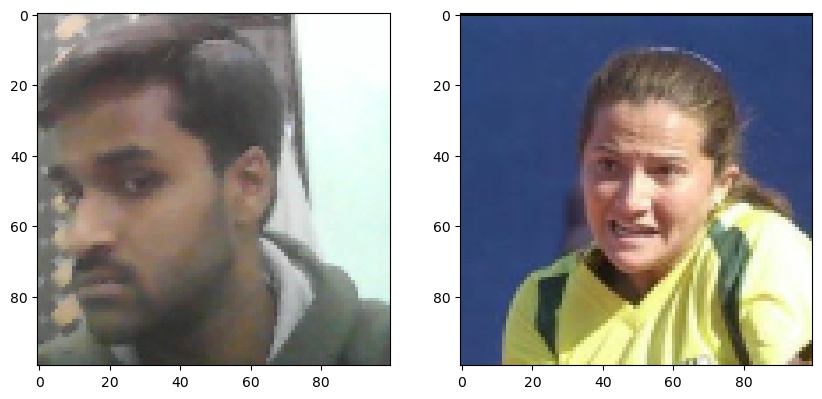

In [196]:
# Set plot size
plt.figure(figsize=(10,8))

# set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

# Save Model

In [197]:
siamese_model.save("siamesemodel.h5")

In [201]:
model = tf.keras.models.load_model("siamesemodel.h5",
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [202]:
model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[0.5020343 ],
       [0.50017846],
       [0.49998176],
       [0.5001418 ],
       [0.49975756],
       [0.50009304],
       [0.50065374],
       [0.49990785],
       [0.501375  ],
       [0.5003084 ],
       [0.50036305],
       [0.50012344],
       [0.5023605 ],
       [0.5012043 ],
       [0.500271  ],
       [0.5001713 ]], dtype=float32)

In [203]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Real Time Test

# Verification Function

In [204]:
os.listdir(os.path.join("application_data", "verification_images"))

['72147374-a57f-11ed-a3d1-6018953feb89.jpg',
 '7258675f-a57f-11ed-a17e-6018953feb89.jpg',
 '73061337-a57f-11ed-9a14-6018953feb89.jpg',
 '74272639-a57f-11ed-b619-6018953feb89.jpg',
 '74934647-a57f-11ed-ad63-6018953feb89.jpg',
 '7525105a-a57f-11ed-b4ce-6018953feb89.jpg',
 '75911083-a57f-11ed-a710-6018953feb89.jpg',
 '76183532-a57f-11ed-b90f-6018953feb89.jpg',
 '7a08a7f4-a57f-11ed-8097-6018953feb89.jpg',
 '7a101811-a57f-11ed-aa1d-6018953feb89.jpg',
 '7a1a3729-a57f-11ed-93c2-6018953feb89.jpg',
 '7a1f5040-a57f-11ed-8d9e-6018953feb89.jpg',
 '7a3ab158-a57f-11ed-b787-6018953feb89.jpg',
 '7a470ff0-a57f-11ed-b6e5-6018953feb89.jpg',
 '7a4c551a-a57f-11ed-ad98-6018953feb89.jpg',
 '7a505792-a57f-11ed-963c-6018953feb89.jpg',
 '7a559f42-a57f-11ed-bd87-6018953feb89.jpg',
 '7a751d9e-a57f-11ed-8248-6018953feb89.jpg',
 '7a7a5e96-a57f-11ed-a6f9-6018953feb89.jpg',
 '7a93dc0a-a57f-11ed-b0e6-6018953feb89.jpg',
 '7a990297-a57f-11ed-a4c7-6018953feb89.jpg',
 '7a9e0daf-a57f-11ed-a15b-6018953feb89.jpg',
 '7aa7864c

In [205]:
for image in os.listdir(os.path.join("application_data", "verification_images")):
    validation_img = preprocess(os.path.join("application_data", "verification_images", image))
    print(validation_img)

tf.Tensor(
[[[0.6904412  0.6904412  0.68259805]
  [0.7022059  0.7022059  0.69436276]
  [0.75147057 0.75147057 0.7436274 ]
  ...
  [0.99215686 1.         0.99607843]
  [0.99215686 1.         0.99607843]
  [0.99215686 1.         0.99607843]]

 [[0.67941177 0.67941177 0.67156863]
  [0.69509804 0.69509804 0.68921566]
  [0.6897059  0.6911765  0.68897057]
  ...
  [0.99215686 1.         0.99607843]
  [0.99215686 1.         0.99607843]
  [0.99215686 1.         0.99607843]]

 [[0.68088233 0.675      0.6759804 ]
  [0.67401963 0.67401963 0.67401963]
  [0.6671569  0.6730392  0.67009807]
  ...
  [0.99215686 1.         0.99607843]
  [0.99215686 1.         0.99607843]
  [0.99215686 1.         0.99607843]]

 ...

 [[0.54338235 0.5776961  0.5237745 ]
  [0.53333336 0.5561274  0.50710785]
  [0.5088235  0.5235294  0.48333332]
  ...
  [0.3485294  0.39240196 0.35955882]
  [0.36691177 0.41789216 0.3884804 ]
  [0.3644608  0.42328432 0.39779413]]

 [[0.5323529  0.5754902  0.5090686 ]
  [0.53357846 0.56691176 0

In [206]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# OpenCV Real Time Verification

In [229]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.7,0.8)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 236ms/step
False


In [215]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [219]:
np.sum(np.squeeze(results) > 0.9)

0

In [220]:
results

[array([[0.5010738]], dtype=float32),
 array([[0.50063944]], dtype=float32),
 array([[0.50019133]], dtype=float32),
 array([[0.50059396]], dtype=float32),
 array([[0.500316]], dtype=float32),
 array([[0.5009624]], dtype=float32),
 array([[0.50066435]], dtype=float32),
 array([[0.50105613]], dtype=float32),
 array([[0.50111586]], dtype=float32),
 array([[0.50111586]], dtype=float32),
 array([[0.5010833]], dtype=float32),
 array([[0.5010833]], dtype=float32),
 array([[0.5010089]], dtype=float32),
 array([[0.50099015]], dtype=float32),
 array([[0.50099015]], dtype=float32),
 array([[0.50099015]], dtype=float32),
 array([[0.5008005]], dtype=float32),
 array([[0.50070196]], dtype=float32),
 array([[0.50070196]], dtype=float32),
 array([[0.50068814]], dtype=float32),
 array([[0.50068814]], dtype=float32),
 array([[0.50068814]], dtype=float32),
 array([[0.5008191]], dtype=float32),
 array([[0.50076896]], dtype=float32),
 array([[0.501422]], dtype=float32),
 array([[0.5014912]], dtype=float32)